In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from tqdm import tqdm_notebook
import warnings
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.multitest import multipletests
from statsmodels.tsa.holtwinters import ExponentialSmoothing

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

### 0. Загрузка данных

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
print(train.shape)
print(test.shape)
print(train.head())

(5000000, 3)
(2000000, 2)
     time  signal  open_channels
0  0.0001 -2.7600              0
1  0.0002 -2.8557              0
2  0.0003 -2.4074              0
3  0.0004 -3.1404              0
4  0.0005 -3.1525              0


### 1. Сигнал и кол-во каналов в зависимости от времени

In [79]:
def draw_time_series(time, data, title, plot_type='plot',
                     multibatch=True):
    plt.figure(figsize=(12,8))
    plt.title(title, fontsize=14)
    
    if plot_type == 'plot':
        plt.plot(time, data, alpha=0.9)
    if plot_type == 'scatter':
        plt.scatter(time, data, alpha=0.3)
    
    if multibatch:
        for i in range(11):
            plt.axvline(50*i, color='black')
        
    plt.xlabel('Time', fontsize=14)
    plt.show()
    

def draw_signal_with_channels(time, signal, channels, title):
    plt.figure(figsize=(12, 8))
    plt.title(title, fontsize=14)
    plt.plot(time, signal, label='signal')
    plt.plot(time, channels, label='channels')
    plt.legend(fontsize=14)
    plt.xlabel('Time', fontsize=14)
    plt.show()

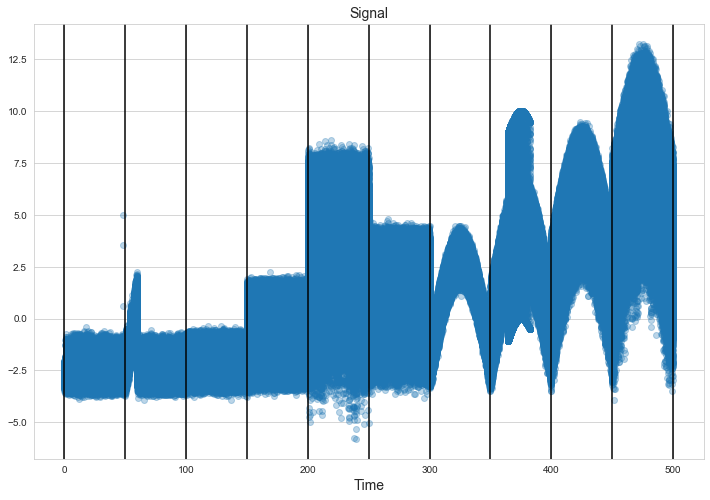

In [24]:
draw_time_series(train.time, train.signal,
                 'Signal', plot_type='scatter')

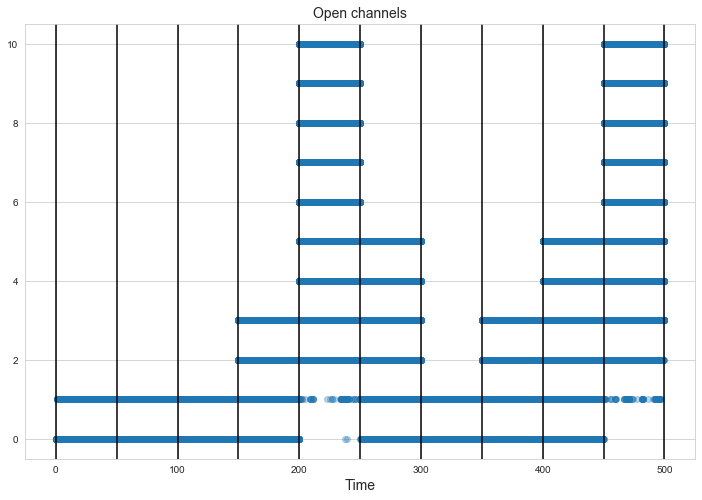

In [25]:
draw_time_series(train.time, train.open_channels, 
                 'Open channels', plot_type='scatter')

**Наблюдения:** 

1) 6 из 10 временных батчей по 50 секунд сигнал колеблется с постоянной дисперсией, причем за короткий промежуток времени успевает принять весь диапазон своих значений в пределах этого батча. Большее количество открытых каналов получается в батчах с большей дисперсией, и соответственно, с большим значением тока, что предсказуемо. Позже проверим эту зависимость статистическими методами.

2) Последние 4 батча напоминают синусоиду, и так же в батчах с меньшими значениями сигнала количество открытых каналов тоже меньше.

Пятый батч в приближении:

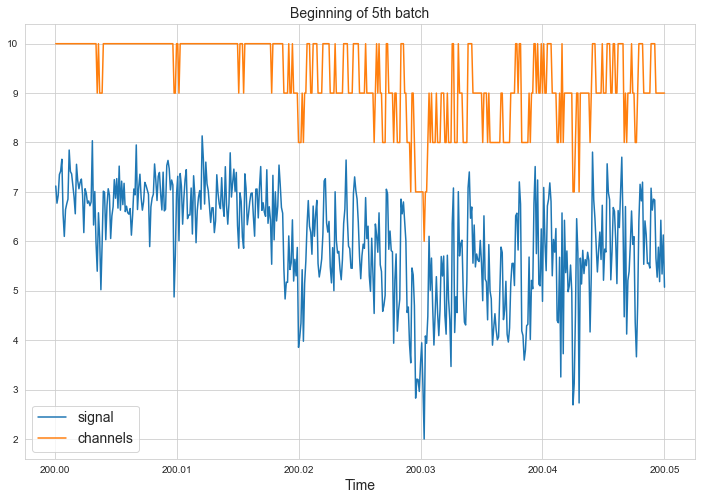

In [35]:
left = 500*(10**3)*4
num_steps = 500
right = left + num_steps
draw_signal_with_channels(train.time[left:right],
                          train.signal[left:right],
                          train.open_channels[left:right],
                          'Beginning of 5th batch')

Девятый батч в приближении:

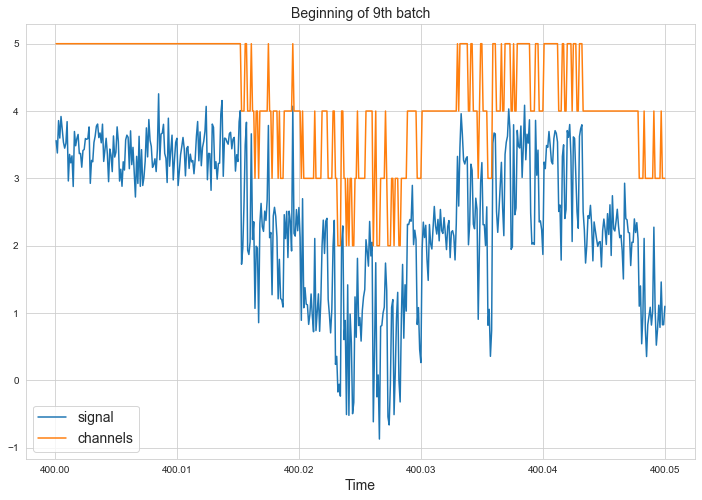

In [36]:
left = 500*(10**3)*8
num_steps = 500
right = left + num_steps
draw_signal_with_channels(train.time[left:right],
                          train.signal[left:right],
                          train.open_channels[left:right],
                          'Beginning of 9th batch')

**Наблюдения:** когда количетсво открытых каналов постоянно, ток может колебаться в некотором диапазоне шириной около двух единиц, закрытие одного-двух каналов ведёт к мгновенному падению тока. "Волатильность" тока при постоянном количестве открытых каналов наводит на мысль, что полезно будет посмотреть на сглаженный график тока, в дальнейшем это может пригодиться для генерации новых признаков (со сглаженным сигналам моделям будет работать явно проще).

### 2. Стационарность временных рядов

Прежде чем что-то думать про тренд и сезонность, проверим, а не являются ли наши временные ряды стационарными. Это поможет понять, в каком направлении стоит двигаться в дальнейшем анализе.

Проверять стационарность будем критерием KPSS, а затем к результатам применим множественную проверку гипотез:

In [68]:
pvalues = []
batch_size = 500*(10**3)

for i in range(10):
    current_batch = train.signal[i*batch_size:(i+1)*batch_size]
    current_batch = np.array(current_batch)
    pvalues.append(kpss(current_batch)[1])
    
multipletests(pvalues)[0]

array([False, False, False, False, False, False, False, False, False,
       False])

**Результат:** гипотеза о стационарности не отвергается ни для одного временного ряда. Значит не стоит особо возится с трендом и сезонностью - скорее всего их нет.

### 3. Выявление сезонности

Тем не менее, нарисовать коррелограммы - никогда не бывает лишним, поэтому все-таки попробуем найти какую-нибудь сезонность в рядах. В конце концов, результат проверки гипотезы о стационарности получился статистически незначимым.

In [83]:
def draw_corr_grams(time, signal):
    batch_size = 500*(10**3)
    num_batches = 10
    
    plt.subplots(num_batches, 2, figsize=(15,10))
    
    for i in tqdm_notebook(range(num_batches)):
        current_batch = signal[i*batch_size:(i+1)*batch_size]
        
        ax = plt.subplot(num_batches, 2, (i*2)+1)
        ax.set_ylabel(f'Batch {i+1}')
        sm.graphics.tsa.plot_acf(current_batch, lags=300, ax=ax)
        
        ax = plt.subplot(num_batches, 2, (i*2)+2)
        sm.graphics.tsa.plot_pacf(current_batch, lags=300, ax=ax)
        
    plt.show()

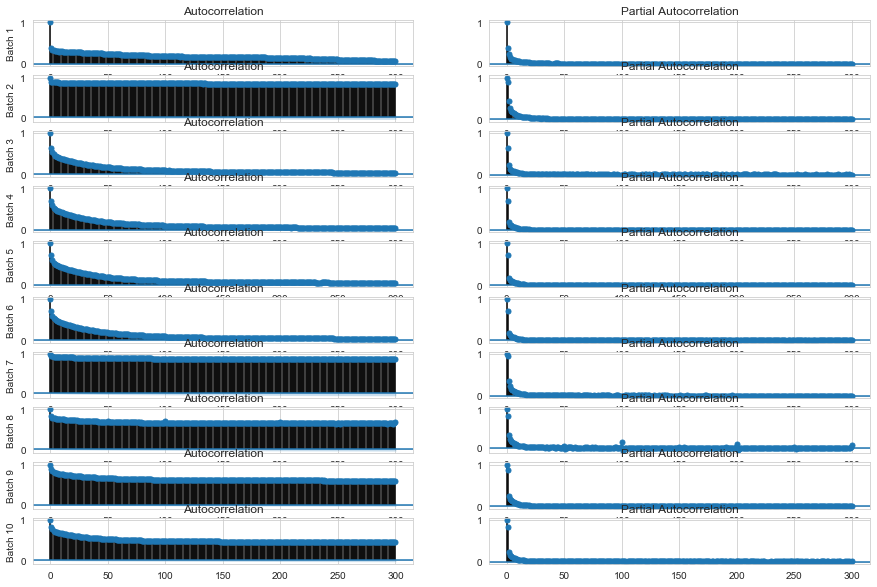

In [84]:
draw_corr_grams(train.time, train.signal)

**Наблюдения:** сезонности сигнала нет ни для одного батча.

### 4. Сглаживание - скользящее среднее

Исследуем способ сглаживания сигнала путём взятия скользящего среднего с разной шириной окна.

In [52]:
def signal_channels_rolling(time, signal, channels, title,
                            rolling, window_size):
    rolling_time = np.array(rolling.dropna().index).astype('float')
    rolling_time = rolling_time / 10000
    rolling_value = np.array(rolling.dropna())

    plt.figure(figsize=(12, 8))
    plt.title(title, fontsize=14)
    plt.plot(time, signal, label='signal', alpha=0.4,
             color='C0')
    
    plt.plot(rolling_time[window_size:],
             rolling_value[window_size:],
             label='rolling_mean', color='C0')
    plt.plot(time, channels, label='channels', color='C1')
    plt.legend(fontsize=14)
    plt.xlabel('Time', fontsize=14)
    plt.show()

In [59]:
window_sizes = [5, 10, 20, 30, 60, 100]
rollings = []

for window_size in tqdm_notebook(window_sizes):
    rollings.append(train.signal
                    .rolling(window=window_size)
                    .mean())

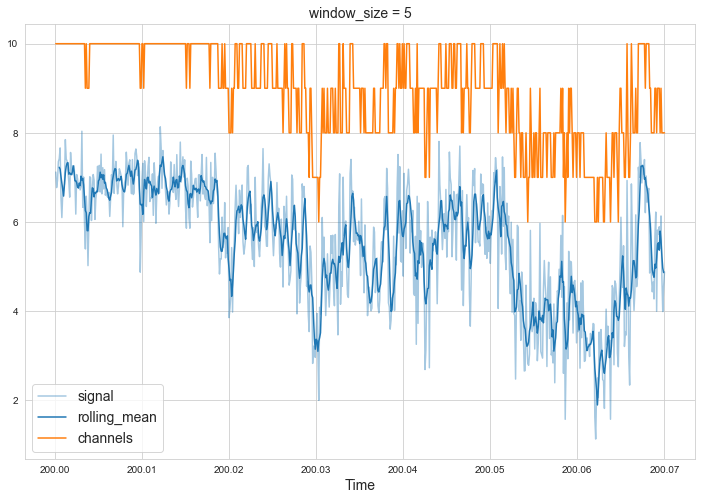

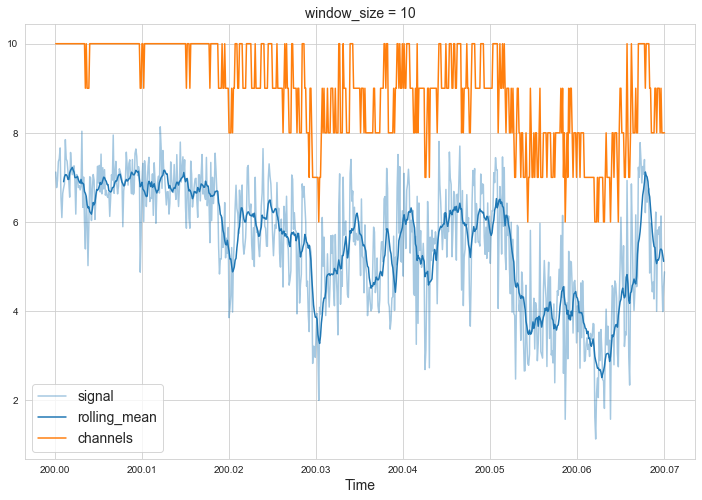

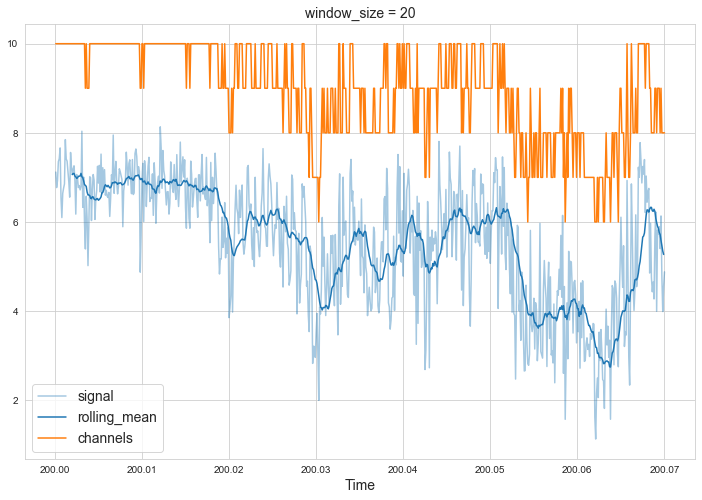

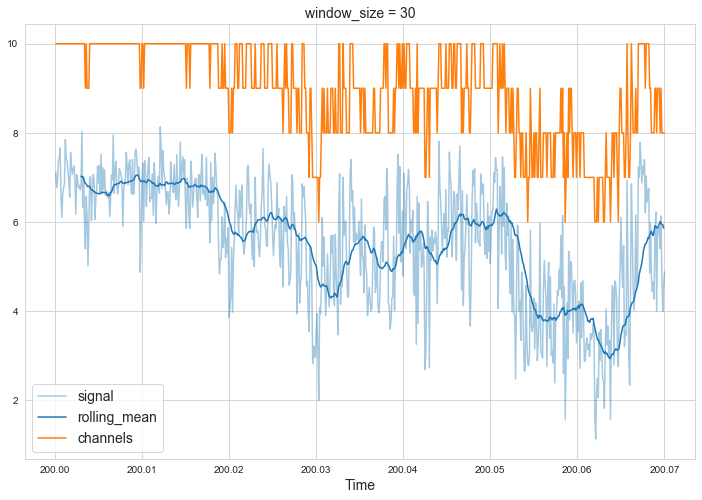

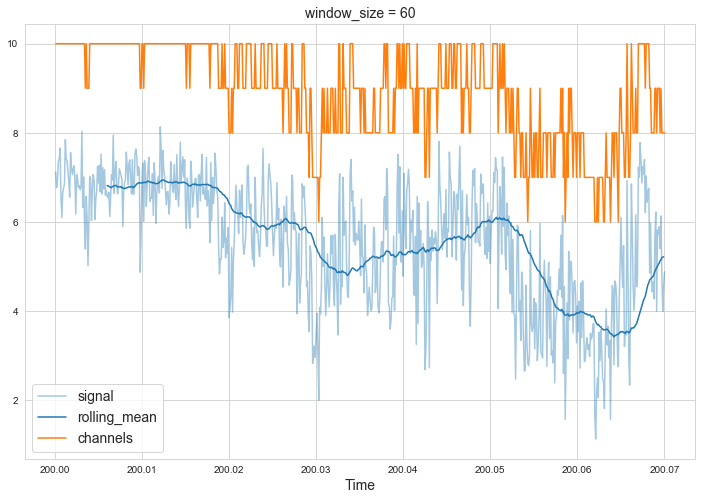

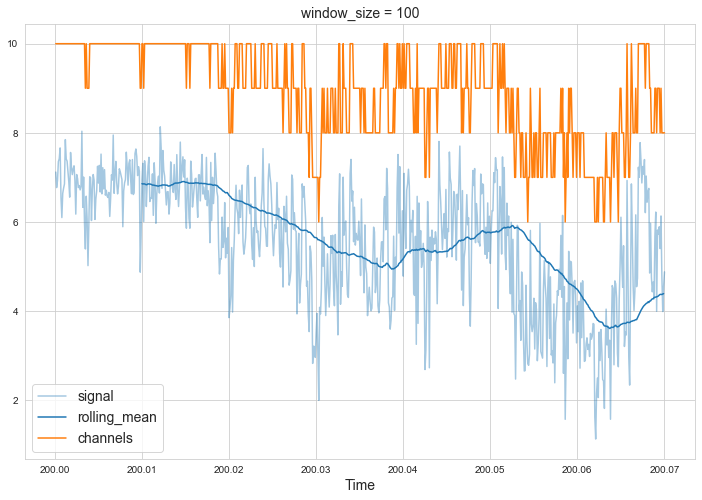

In [60]:
left = 500*(10**3)*4
num_steps = 700
right = left + num_steps

for i, window_size in enumerate(window_sizes):
    signal_channels_rolling(train.time[left:right],
                            train.signal[left:right],
                            train.open_channels[left:right],
                            f'window_size = {window_size}',
                            rollings[i][left:right],
                            window_size=window_size)

**Наблюдения:** рисунок скользящего среднего хорошо повторяет рисунок изменения количества открытых каналов, а значит при feature engineering нужно будет добавить побольше различных скользящих статистик. Особенно хорошо смотрится скользящее среднее по окну размера 20, там и дисперсия хорошо сглаживается, и мелкие изменения количества открытых каналов все равно остаются заметными.

### 5. Экспоненциальное сглаживание

Рассмотрим также вариант экспоненциального сглаживания.

In [74]:
def exponential_smoothing(y, alpha):
    res = np.zeros(len(y))
    res[0] = y[0]
    
    for i in range(1, len(y)):
        res[i] = res[i-1] + alpha*(y[i] - res[i-1])
        
    return res


def signal_channels_exp(time, signal, channels, title, exp):
    plt.figure(figsize=(12, 8))
    plt.title(title, fontsize=14)
    plt.plot(time, signal, label='signal', alpha=0.4,
             color='C0')
    plt.plot(time, exp,
             label='exp smoothing', color='C0')
    plt.plot(time, channels, label='channels', color='C1')
    plt.legend(fontsize=14)
    plt.xlabel('Time', fontsize=14)
    plt.show()

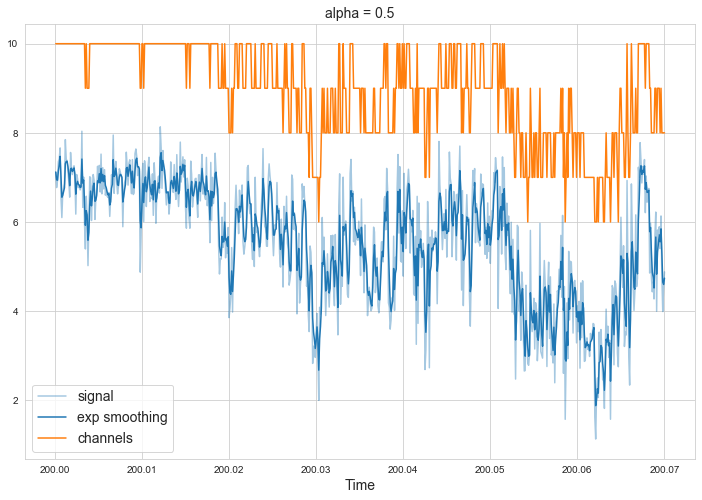

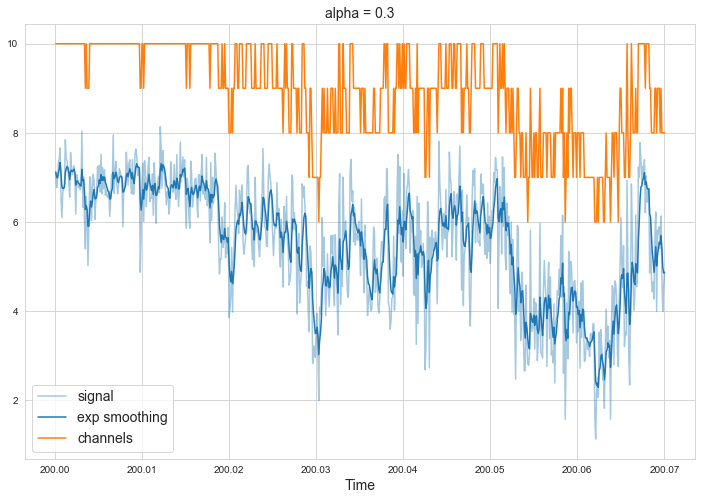

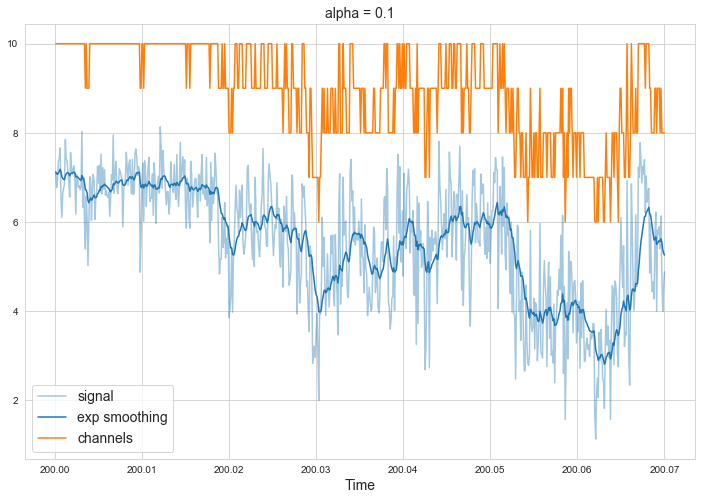

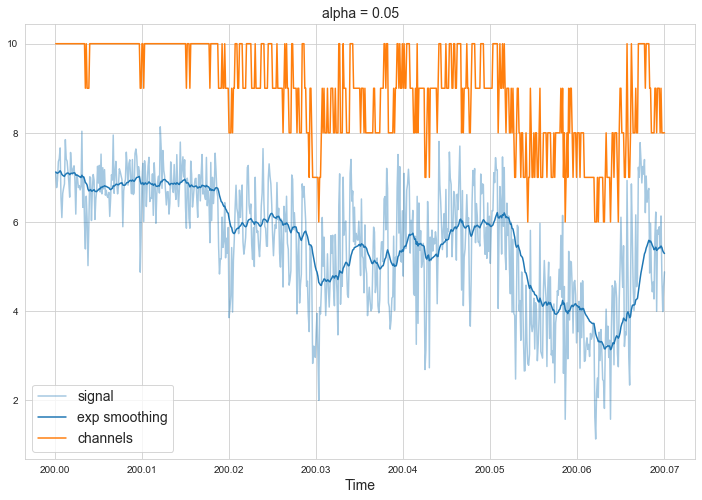

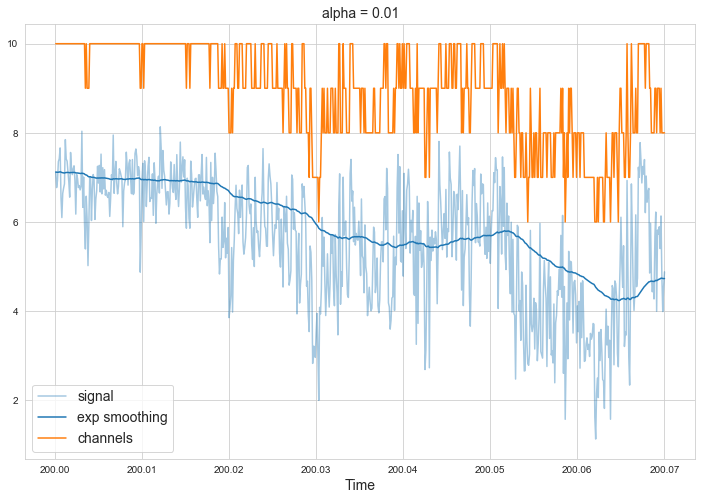

In [78]:
alphas = [0.5, 0.3, 0.1, 0.05, 0.01]

left = 500*(10**3)*4
num_steps = 700
right = left + num_steps

for i, alpha in tqdm_notebook(enumerate(alphas)):
    exp = exponential_smoothing(np.array(train.signal[left:right]),
                                alpha=alpha)
    signal_channels_exp(train.time[left:right],
                        train.signal[left:right],
                        train.open_channels[left:right],
                        f'alpha = {alpha}',
                        exp)

**Наблюдения:** при alpha = 0.05, сглаженный график учитывает и мелкие колебания количества открытых каналов, и хорошо снижает волатильность. Учтем это также при генерации новых признаков.

### 6. График тестовой выборки

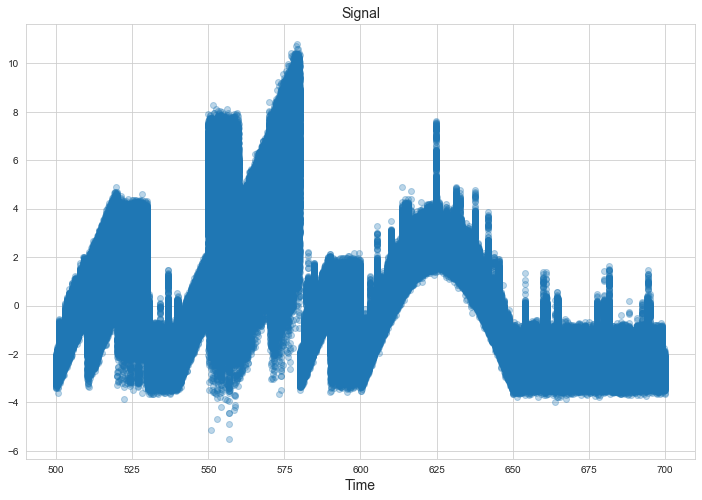

In [80]:
draw_time_series(test.time, test.signal,
                 'Signal', plot_type='scatter', multibatch=False)

**Наблюдения:** видно, что к батчам на тесте тоже были применены некоторые преобразования, похожие на синус и линейную функцию. При обучении моделей нужно будет попробовать избавиться от этого, а еще стоит попробовать применят разные модели для разных рисунков сигнала (например, предсказывать третий батч на тесте моделью, обучающейся на последних 4-х батчах из теста, т.к. рисунок сигнала у них похож).

### 7. Статистики, сагрегированные по батчам

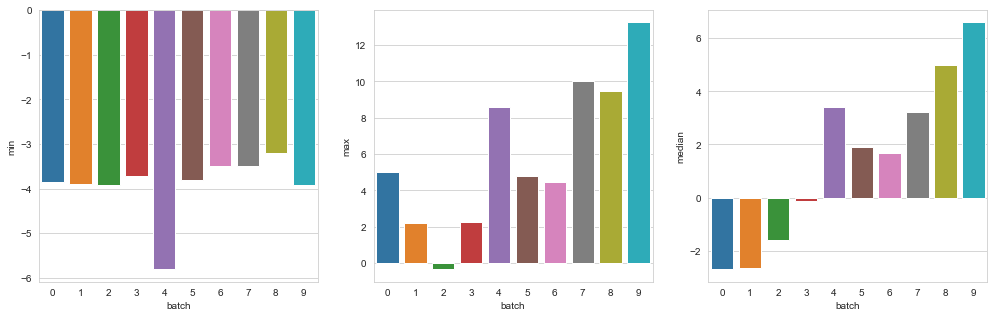

In [4]:
def plot_batch_stats(df, batch_size=50 * 10**4):
    df = df.copy()
    
    stats = ['min', 'max', 'median']
    df['batch'] = df['batch'] = df.index // batch_size
    by_batch = df.groupby(['batch'])['signal'].agg(stats).reset_index()
    
    
    plt.figure(figsize=(17, 5))
    for i, curr_stat in enumerate(stats):
        plt.subplot(1, 3, i+1)
        
        sns.barplot(y=curr_stat, x='batch', data=by_batch)

plot_batch_stats(train)

**Наблюдение:** если собирать статистики по данным в пределах конкретных батчей, то с помощью них можно четко различить батчи друг от друга, а значит это однознанчно надо внедрить в feature_engineering.